In [12]:
# data_root = "/kaggle/input/nasdaq100-stock-price-data/"
data_root = "../data/"
#stats stuff
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# ML stuff
import numpy as np
from numpy.fft import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import Lasso
import pandas as pd
import lightgbm as lgb


# DL stuff
from torch.autograd import Variable
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# plotting
import matplotlib.pyplot as plt
import seaborn as sns



# basic stuff
import datetime
import io
import os
from os.path import join
from collections import Counter
from tqdm import tqdm

# relative imports
# from LSTM_preprocess import get_Xy, get_train_test, get_train_df, sliding_windows_mutli_features
# from hfuncs import check_mkdir

- functions cell below

In [106]:
########################################################################
################## this cell is dedicated to kaggle ####################
########################################################################

# set index as datetime
def date_index_nasdaq(nasdaq):
    nasdaq_c = nasdaq.copy()
    dates = pd.to_datetime(nasdaq_c.Date)
    nasdaq_c.set_index(dates, inplace=True)
    # set date as index
    nasdaq_c.drop("Date", axis=1, inplace=True)
    # ここでFBとかTESLAとかに合わせている
    nasdaq_c = nasdaq_c["2012-05-18":]
    return nasdaq_c

############## REINDEX FUNCTION AND PREPARE_STOCK FUNCTION ARE PRETTY MUCH SAME, HOWEVER, I PREFER THE PRIOR ##################
# for ARIMA or some shit    
def reindex(df):
    return df.reindex(pd.date_range(df.index[0], df.index[-1])).fillna(method="ffill")

# for prepare_stock
def date_range_df(start, end, column_name = "Time"):
    date_range = pd.date_range(start, end)
    df = pd.DataFrame(date_range, columns = [column_name])
    df.set_index(column_name, inplace=True)
    return df

# merging with date range df
def prepare_stock(nasdaq, start, end, stock_name="AAPL", drop=True):
    nasdaq = nasdaq.loc[nasdaq["Name"]==stock_name]
    dates = date_range_df(start, end)
    new_nasdaq = dates.merge(nasdaq, how="left", left_index=True, right_index=True)
    if drop:
        new_nasdaq.dropna(inplace=True)
    return new_nasdaq
#############################################################################################################################

# create log_Volatility, log_Volume, log_Adj_Close and drop Adj_Close if not included in features
def get_features(df, features):
    #rename Adj Close
    
    
    df.rename(columns={"Adj Close":"Adj_Close"}, inplace=True) 
    df["log_Volatility"] = np.log(df.High - df.Low + 1)
    df["log_Volume"] = np.log(df.Volume + 1) 
    df["log_Adj_Close"] = np.log(df["Adj_Close"] + 1)
    # df["day_of_week"] = np.array(list(map(lambda date: date.weekday(), df.index)))

    if 'Adj_Close' not in features:
        df.drop(columns=["Adj_Close"], inplace=True)
    # nasdaq["log_Adj_Close_diff"] = nasdaq["log_Adj_Close"].diff()

    df.drop(columns = ["Low", "High", "Close", "Open", "Name", "Volume"], inplace=True)
    # nasdaq = nasdaq[features]

    # nasdaq.dropna(inplace = True)
    return df

# this will return feature engineered stock dataframe
def get_stock(nasdaq, features, stock_name="AAPL"):
    nasdaq_c = date_index_nasdaq(nasdaq)
    stock = prepare_stock(nasdaq_c, nasdaq_c.index[0], nasdaq_c.index[-1], stock_name)
    stock = get_features(stock, features)
    stock.fillna("ffill", inplace=True)
    return stock

# plot heatmap for top stocks
def plot_attribute(nasdaq, using,feature="log_Adj_Close"):
    stocks = pd.DataFrame()
    for name in using:
        stocks[name] = get_stock(nasdaq, name)[feature]
    stocks.dropna(inplace=True)
    stocks.plot()
    plt.show()




def sliding_windows_mutli_features(data, seq_length, target_cols_ids):
    x = []
    y = []

    for i in range((data.shape[0])-seq_length-1):
        #change here after finishing feature engineering process
        _x = data[i:(i+seq_length), :] 
        _y = data[i+seq_length, target_cols_ids] ## column 1 contains the labbel(log_Adj_Close)
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

def get_Xy(df, window_size):
    log_adj_close_cols_ids = []
    volatility_cols_ids = []
    volume_cols_ids = []
    weekday_col_id = []
    count = 0
    for col in df.columns:
        # print(col)
        if col[1] == "Adj_Close":
            df.drop(col, axis=1, inplace=True)
            count -= 1
        if col[1] == "log_Adj_Close":
            log_adj_close_cols_ids.append(count)
        if col[1] == "log_Volume":
            volume_cols_ids.append(count)
        if col[1] == "log_Volatility":
            volatility_cols_ids.append(count)
        if col[0] == "weekday":
            weekday_col_id.append(count)
        count += 1
    df = df.to_numpy()
    x, y = sliding_windows_mutli_features(df, window_size, log_adj_close_cols_ids)

    # x.shape, y.shape
    return x, y

def get_train_test(x, y, train_ratio):
    train_size = int(len(y)*train_ratio)
    test_size = len(y) - train_size

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

    testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

    return trainX, trainY, testX, testY


def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)


def binary_y(y_np, criterion):
    y_np_c = y_np.copy()
    for i in range(len(y_np_c)):
        if y_np_c[i] > criterion:
            y_np_c[i] = int(1)
        else:
            y_np_c[i] = int(0)
        
    return y_np_c


def sliding_windows_single_feature(X, y, seq_length):
    x = []
    Y = []

    for i in range((X.shape[0])-seq_length-1):
        #change here after finishing feature engineering process
        _x = X[i:(i+seq_length), :] 
        _y = y[i+seq_length] ## column 1 contains the labbel(log_Adj_Close)
        x.append(_x)
        Y.append(_y)

    return np.array(x), np.array(Y)

def get_bc_per_stock_Xy(nasdaq, features, stock_name, train_ratio):
    stock = get_stock(nasdaq, features, stock_name)

    stock_new = stock.copy()
    stock_log_adj = stock["log_Adj_Close"]
    stock_log_adj_diff = stock_log_adj.shift(-1) - stock_log_adj
    stock_new["log_Adj_Close"] = stock_log_adj_diff # tomorrow - today
    X = stock_new
    y = stock_new["log_Adj_Close"].iloc[1:-1] #　そのまま, getting rid of nan although ind 0 is not nan for y
    X["log_Adj_Close"] = stock_new["log_Adj_Close"].shift(1) # today - yesterday
    X = X.iloc[1:-1] # getting rid of nans
    new_index = y.index

    scaler = MinMaxScaler(feature_range=(-1, 1))
    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y.to_numpy().reshape(-1,1))

    # to 1 and 0 two class classification
    X[:, 2] = binary_y(X[:, 2], c)
    y = binary_y(y, c)

    X, y = sliding_windows_single_feature(X, y, 50)

    train_size = int(X.shape[0]*train_ratio)
    
    X_train, X_test = X[:train_size, :, :], X[train_size:, :, :]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test



In [107]:
#################### LOAD DATA ######################
################ DEFINE CONSTANTS ###################
##### we will only predict for one stock here #######

nasdaq = pd.read_csv(data_root + "NASDAQ_100_Data_From_2010.csv", sep="\t")

# 'FOR APPLE, WE SET CRITERION AS 0.14'
# for c in [0.25,0.2,0.15, 0.14, 0.1, 0.05, 0.03]:
#     print(c)
#     print(Counter(binary_y(list(X[2]), c)))
#     print(Counter(binary_y(list(y), c)))

c = 0.14 # this is for scaled apple stock 
window_size = 50
train_ratio = 0.8316
batch_size = 381 # 366.4 is len(train)/5 if train_ratio == 0.80
stock_name = "AAPL"
DROPOUT = 0.2
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# the order of the features is extremely important for latter indexing so make sure
features = ['log_Volatility', 'log_Volume', 'log_Adj_Close']
dirname = f"{stock_name}_bc"
check_mkdir(dirname)
# using = ['FB', 'TSLA', 'AAPL', 'AMZN', 'NVDA', 'MSFT', 'GOOGL']
# AAPL(Apple), MSFT(Microsoft), GOOGL(Google), AMZN(Amazon), TSLA(Tesla), FB(Facebook), NVDA(Nvidia)

# return scaled numpy array of train, test sets of one stock
X_train, X_test, y_train, y_test = get_bc_per_stock_Xy(nasdaq, features, stock_name, train_ratio)

- lstm cell below

In [108]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length

        self.dropout = nn.Dropout(p=DROPOUT)
        
        # what does the batch_first do
        self.lstm = nn.LSTM(\
            input_size=input_size, 
            hidden_size=hidden_size,
            num_layers=num_layers, 
            batch_first=True,
            )
        
        # Linear(in_features, out_features)
        self.fc = nn.Linear(hidden_size, num_classes) 
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)                                         
        out = self.dropout(out)
        
        out = self.sigmoid(out)
       
        return out
    
def init_weights(model):
    for name, param in model.named_parameters():
        nn.init.uniform_(param.data, -0.88, 0.08)

# create a nn class (just-for-fun choice :-) 
# class RMSELoss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.mse = nn.MSELoss()
        
#     def forward(self,yhat,y):
#         return torch.sqrt(self.mse(yhat,y))


class PearsonLoss(nn.Module):
    def forward(self, x, y):
        vx = x - torch.mean(x)
        vy = y - torch.mean(y)
        
class BCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()
        
    def forward(self, yhat, y):
        return self.bce(yhat, y)


In [109]:
###### Parameters #######
num_epochs = 300
learning_rate = 1e-3
input_size = 3 # features
hidden_size = 512
num_layers = 1 # changed from one because of dropout error -> prob diff
num_classes = 1 # because we are using 1 stock
#########################
best_val_loss = 100    


In [110]:
### Init Model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

# lstm.apply(init_weights) #is this necessary?
trainX, trainY = Variable(torch.Tensor(X_train)), Variable(torch.Tensor(y_train))
testX, testY = Variable(torch.Tensor(X_test)), Variable(torch.Tensor(y_test))

In [117]:
load_path = "LSTM_binary_classification_2/best_model_bc_batch_trained.pt"
state_dict = torch.load(load_path, map_location=device)
    
lstm.load_state_dict(state_dict)

<All keys matched successfully>

In [122]:
# plot predictions
pred = lstm(testX.to(device))

pred_cpu = pred.detach().cpu().numpy()
testY_cpu = testY.detach().cpu().numpy()
scaler = MinMaxScaler((0,1))
pred_cpu = scaler.fit_transform(pred_cpu)
testY_cpu = scaler.fit_transform(testY_cpu)


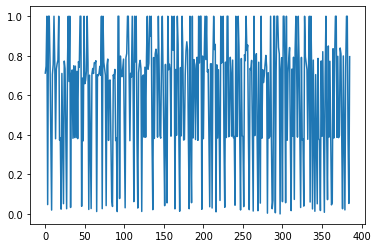

In [123]:
plt.plot(pred_cpu)

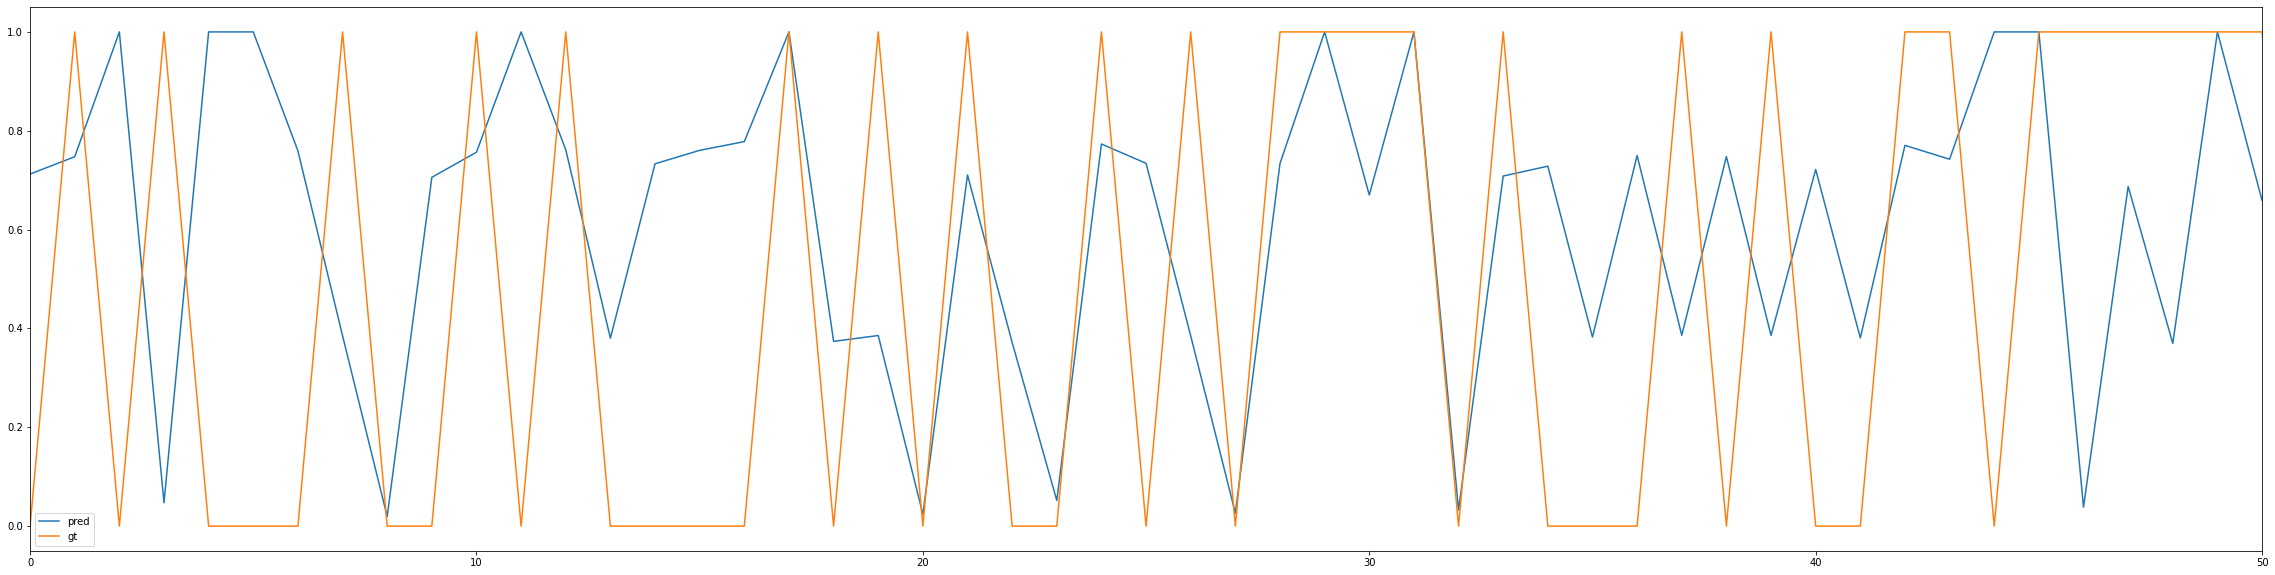

0.06825680189138882
-0.007568493614446022


In [126]:
plt.figure(figsize=(40, 10))
plt.plot(pred_cpu)
plt.plot(testY_cpu)
plt.legend(["pred", "gt"])
plt.xlim(0, 50)
plt.savefig("images/lstm_bc_2_1.png")
plt.show()
# plt.ylim((0.3, 0.45))

# coefs
gaussian = np.random.random(testY_cpu_arr.shape)
fpr, tpr, thresholds_ = metrics.roc_curve(testY_cpu_arr, pred_cpu_arr)
print(np.corrcoef(pred_cpu.squeeze(), testY_cpu.squeeze())[0][1])
print(np.corrcoef(gaussian, testY_cpu_arr)[0][1])
pred_cpu_arr, testY_cpu_arr = pred_cpu.squeeze(), testY_cpu.squeeze()

In [99]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
gaussian = np.random.random(testY_cpu_arr.shape)
fpr, tpr, thresholds_ = metrics.roc_curve(testY_cpu_arr, pred_cpu_arr)
fpr_, tpr_, thresholds_ = metrics.roc_curve(testY_cpu_arr, gaussian)
metrics.auc(fpr, tpr), metrics.auc(fpr_, tpr_)

ValueError: continuous format is not supported

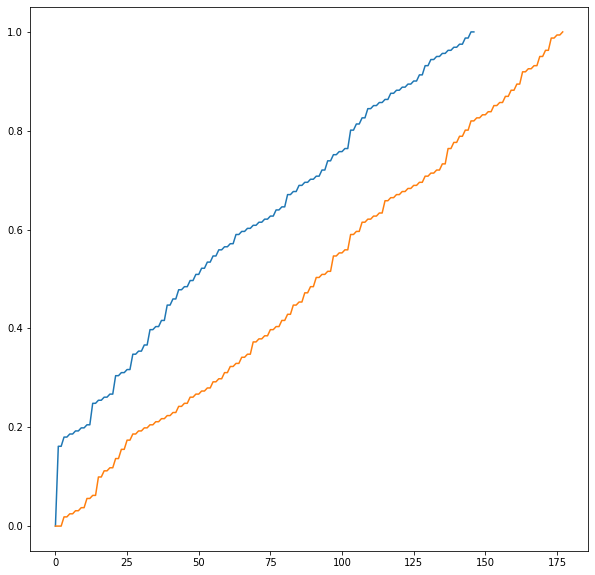

In [93]:
plt.figure(figsize=(10, 10))
plt.plot(tpr)
plt.plot(tpr_)

In [76]:
for lil in np.arange(-0.05, 0.15, 0.005):
    pred_bin_cpu = binary_y(pred_cpu, np.mean(pred_cpu_arr)+lil)
    print(accuracy_score(pred_bin_cpu, testY_cpu_arr), ">>>", np.mean(pred_cpu.squeeze())+lil, lil)

0.48186528497409326 >>> 0.37000165581703187 -0.05
0.5077720207253886 >>> 0.3750016558170319 -0.045000000000000005
0.5051813471502591 >>> 0.3800016558170318 -0.04000000000000001
0.5051813471502591 >>> 0.38500165581703183 -0.03500000000000001
0.5051813471502591 >>> 0.39000165581703183 -0.030000000000000013
0.5051813471502591 >>> 0.39500165581703184 -0.025000000000000015
0.5051813471502591 >>> 0.40000165581703184 -0.020000000000000018
0.5051813471502591 >>> 0.40500165581703185 -0.01500000000000002
0.5051813471502591 >>> 0.41000165581703185 -0.010000000000000023
0.5051813471502591 >>> 0.41500165581703186 -0.005000000000000025
0.5051813471502591 >>> 0.42000165581703186 -2.7755575615628914e-17
0.5051813471502591 >>> 0.4250016558170318 0.00499999999999997
0.5051813471502591 >>> 0.4300016558170318 0.009999999999999967
0.5051813471502591 >>> 0.4350016558170318 0.014999999999999972
0.5259067357512953 >>> 0.4400016558170318 0.019999999999999962
0.5362694300518135 >>> 0.4450016558170318 0.02499999

In [24]:
accuracy_score(pred_bin_cpu.squeeze(), testY_cpu.squeeze())

0.5207253886010362

In [7]:
batch_end_idxs = []
for idx in range(1, X_train.shape[0]+1):
    if idx % batch_size == 0:
        batch_end_idxs.append(idx-1)

# making sure batch_end ends at end of X_train
assert batch_end_idxs[-1] == X_train.shape[0] - 1 

In [8]:
############################################################################################
############################################################################################
############################### ONLY RUN FOR TRAINING ######################################
############################################################################################
############################################################################################

        
### Set Criterion Optimizer and scheduler
criterion = torch.nn.BCELoss().to(device) 
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5, min_lr=1e-7, eps=1e-08)

#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)


optimizer.zero_grad() # moved this out of loop 
vall_losses = []
train_losses = []

# Train model
############### 
batch_start_idx = 0
for epoch in progress_bar(range(num_epochs)):
    lstm.train()
    
    loss_per_batch = []
    for batch_end_idx in batch_end_idxs:
        trainX, trainY = trainX[batch_start_idx:batch_end_idx, : , :], trainY[batch_start_idx:batch_end_idx]
#         print(trainX.shape, trainY.shape)
        
        outputs= lstm(trainX.to(device))
        torch.nn.utils.clip_grad_norm_(lstm.parameters(),1)

        # obtain loss func
        loss = criterion(outputs, trainY.to(device))
        loss_per_batch.append(loss.detach().cpu().item())
        loss.backward()

        scheduler.step(loss)
        optimizer.step()
        
    loss_per_batch_mean = np.mean(np.array(loss_per_batch))
    train_losses.append(loss_per_batch_mean)

    #evaluate on test
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    vall_losses.append(vall_loss)

    scheduler.step(vall_loss)
    
    

    if vall_loss.cpu().item() < best_val_loss:
        torch.save(lstm.state_dict(), dirname + "/" + f'best_model.pt')
        print("saved model epoch:",epoch,"val loss is:",vall_loss.cpu().item())
        best_val_loss = vall_loss.cpu().item()

    if epoch % 50 == 0:
        print(f"Epoch: {epoch}, loss: {loss_per_batch_mean}, valid loss:{vall_loss.cpu().item()}")

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(vall_losses)
plt.plot(train_losses)

In [ ]:

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

In [ ]:
# plot predictions
pred = lstm(testX.to(device))
pred_cpu = pred.detach().cpu().numpy()
testY_cpu = testY.detach().cpu().numpy()
scaler = StandardScaler()
pred_cpu = scaler.fit_transform(pred_cpu)
testY_cpu = scaler.fit_transform(testY_cpu)
plt.plot(pred_cpu)
plt.plot(testY_cpu)
plt.legend(["pred", "gt"])
plt.show()
# plt.xlim(0, 50)
# plt.ylim((0.3, 0.45))

# coefs
np.corrcoef(pred_cpu.squeeze(), testY_cpu.squeeze())

In [ ]:
def data_train_results(lstm, nasdaq, features, stock_name):
    X_train, X_test, y_train, y_test = get_bc_per_stock_Xy(nasdaq, features, stock_name)
    # lstm.apply(init_weights) #is this necessary?
    trainX, trainY = Variable(torch.Tensor(X_train)), Variable(torch.Tensor(y_train))
    testX, testY = Variable(torch.Tensor(X_test)), Variable(torch.Tensor(y_test))

    

    ### Set Criterion Optimizer and scheduler
    criterion = torch.nn.BCELoss().to(device) 
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=1e-5)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5, min_lr=1e-7, eps=1e-08)

    #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

    optimizer.zero_grad()
    # Train model


    ############### 
    for epoch in progress_bar(range(num_epochs)):
        lstm.train()
        outputs= lstm(trainX.to(device))
        torch.nn.utils.clip_grad_norm_(lstm.parameters(),1)

        # obtain loss func
        loss = criterion(outputs, trainY.to(device))
        loss.backward()

        scheduler.step(loss)
        optimizer.step()

        #evaluate on test
        lstm.eval()
        valid = lstm(testX.to(device))
        vall_loss = criterion(valid, testY.to(device))

        scheduler.step(vall_loss)
        
        model_directory = check_mkdir(f"{stock_name}_models")
        if vall_loss.cpu().item() < best_val_loss:
            torch.save(lstm.state_dict(), model_directory + "/" + f'{stock_name}_best_model_{epoch}.pt')
            print("saved best model epoch:",epoch,"val loss is:",vall_loss.cpu().item())
            best_val_loss = vall_loss.cpu().item()

        if epoch % 50 == 0:
            print(f"Epoch: {epoch}, loss: {loss.cpu().item()}, valid loss:{vall_loss.cpu().item()}")
